In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, mean_squared_log_error
%matplotlib inline

In [2]:
mortgage = pd.read_csv('mortgage_data.csv')
auction = pd.read_csv('auction_data.csv')

### default column

In [3]:
# mortgage defaulted
# if any of the pmt columns have 0 in them 
pmt_columns = [f'pmt_{year}' for year in range(1, 31)]
mortgage['default'] = mortgage[pmt_columns].apply(lambda row: 1 if any(row == 0) else 0, axis=1)

### deafult per year


In [4]:
for index, row in mortgage.iterrows():
    for col in pmt_columns:
        year =  col.split('_')[1]
        mortgage.at[index, f'default_{year}'] = 1 if row[col] == 0 else 0
mortgage.head()

,loan_index,property_value,house_indicator,credit_score,married,num_dependents,education,annual_income,coapplicant_indicator,coapplicant_income,...,default_21,default_22,default_23,default_24,default_25,default_26,default_27,default_28,default_29,default_30
0,0,1034333.55,1,689,0,0,Bachelors Degree,183896.81,0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,942811.10,1,620,0,0,Bachelors Degree,182878.90,1,155627.09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,438038.56,1,722,1,1,Began Bachelors,70405.18,0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3,992154.42,1,636,1,2,High School,135044.99,1,118209.66,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4,628359.44,1,620,1,1,High School,99933.09,0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Relative cash flow of mortgage

In [5]:
mortgage['total_cashflow'] = mortgage[pmt_columns].sum(axis=1)
mortgage['relative_cashflow'] = mortgage['total_cashflow'] / (mortgage['pmt']*30)
mortgage['relative_cashflow'] = mortgage['relative_cashflow'].round(decimals=2)

### Number of years of cashflow

In [6]:
for index, row in mortgage.iterrows():
    for col in reversed(pmt_columns):
        if row[col] != 0:
            mortgage.at[index, 'years_of_cashflow'] = int(col.split('_')[1])
            break
mortgage.fillna(0, inplace=True)


### Adjusted income based on cosigner

In [7]:
mortgage[['coapplicant_income']] = mortgage[['coapplicant_income']].fillna(value=0)
mortgage['adjusted_income'] = mortgage['annual_income'] + 0.3 * mortgage['coapplicant_income']

In [8]:
mortgage.head()

,loan_index,property_value,house_indicator,credit_score,married,num_dependents,education,annual_income,coapplicant_indicator,coapplicant_income,...,default_25,default_26,default_27,default_28,default_29,default_30,total_cashflow,relative_cashflow,years_of_cashflow,adjusted_income
0,0,1034333.55,1,689,0,0,Bachelors Degree,183896.81,0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,2016578.10,1.00,30.0,183896.810
1,1,942811.10,1,620,0,0,Bachelors Degree,182878.90,1,155627.09,...,0.0,0.0,0.0,0.0,0.0,0.0,1869472.80,1.00,30.0,229567.027
2,2,438038.56,1,722,1,1,Began Bachelors,70405.18,0,0.00,...,1.0,1.0,1.0,1.0,1.0,1.0,197679.72,0.23,7.0,70405.180
3,3,992154.42,1,636,1,2,High School,135044.99,1,118209.66,...,1.0,1.0,1.0,1.0,1.0,1.0,1110404.81,0.57,17.0,170507.888
4,4,628359.44,1,620,1,1,High School,99933.09,0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,1245955.50,1.00,30.0,99933.090


### Let's do some analysis to see the effect of different variables on defaults

### Histrogram (income vs default count)

In [9]:
default_mortgage = mortgage[mortgage['default'] == 1]
no_default_mortgage = mortgage[mortgage['default'] == 0]

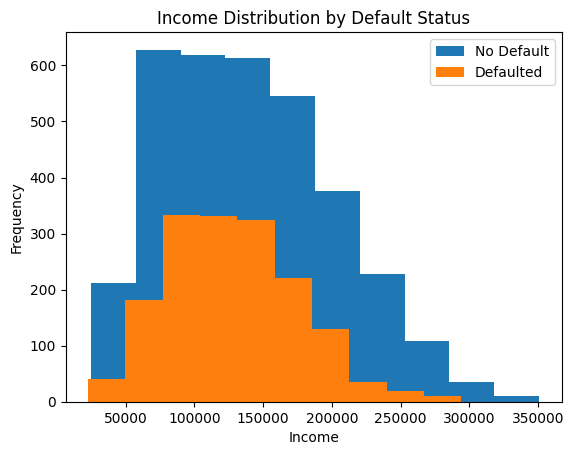

In [10]:
plt.hist(no_default_mortgage['annual_income'], bins=10, alpha=1, label='No Default')
plt.hist(default_mortgage['annual_income'], bins=10, alpha=1, label='Defaulted')

plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('Income Distribution by Default Status')
plt.legend()

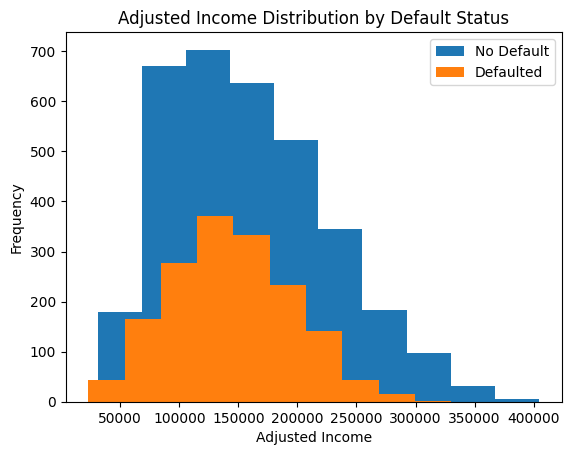

In [11]:
plt.hist(no_default_mortgage['adjusted_income'], bins=10, alpha=1, label='No Default')
plt.hist(default_mortgage['adjusted_income'], bins=10, alpha=1, label='Defaulted')

plt.xlabel('Adjusted Income')
plt.ylabel('Frequency')
plt.title('Adjusted Income Distribution by Default Status')
plt.legend()

### Scatter Plot of Annual Income vs the relative total cash flow

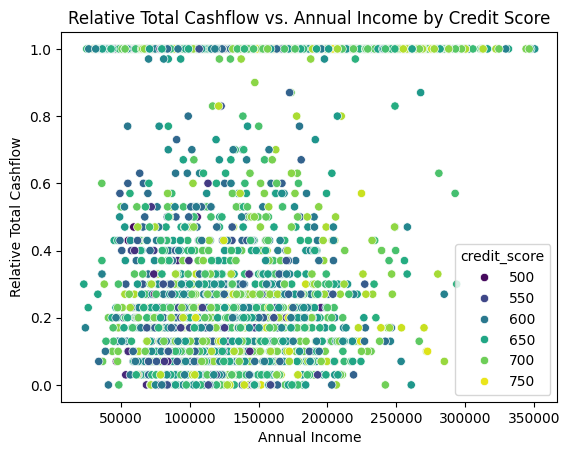

In [12]:
sns.scatterplot(data=mortgage, x='annual_income', y='relative_cashflow', hue='credit_score', palette='viridis')
plt.title('Relative Total Cashflow vs. Annual Income by Credit Score')
plt.xlabel('Annual Income')
plt.ylabel('Relative Total Cashflow')
plt.show()

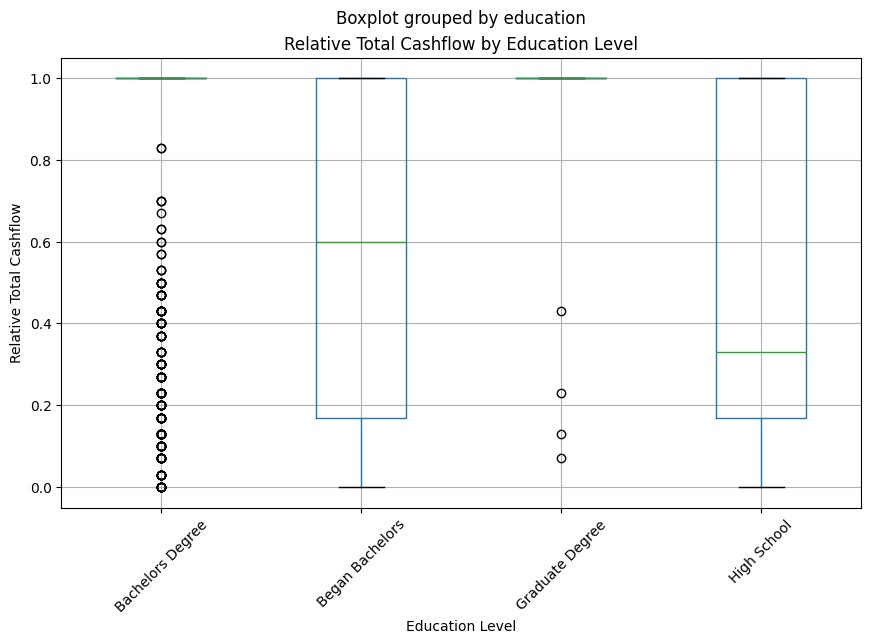

In [13]:
mortgage.boxplot(column='relative_cashflow', by='education', figsize=(10,6))
plt.title('Relative Total Cashflow by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Relative Total Cashflow')
plt.xticks(rotation=45)  # Rotate labels to avoid overlap
plt.show()

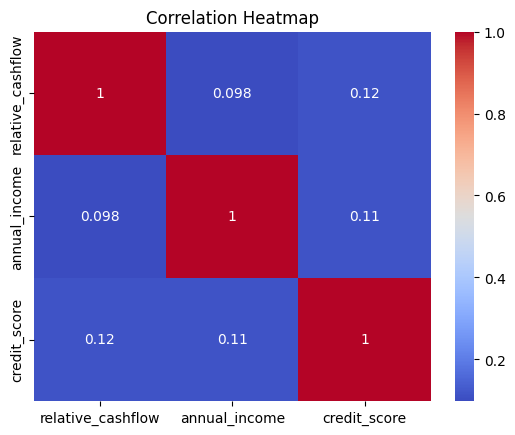

In [14]:

# Selecting a subset of variables to analyze
subset_df = mortgage[['relative_cashflow', 'annual_income', 'credit_score']]

# Calculating correlations
corr = subset_df.corr()

# Plotting heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


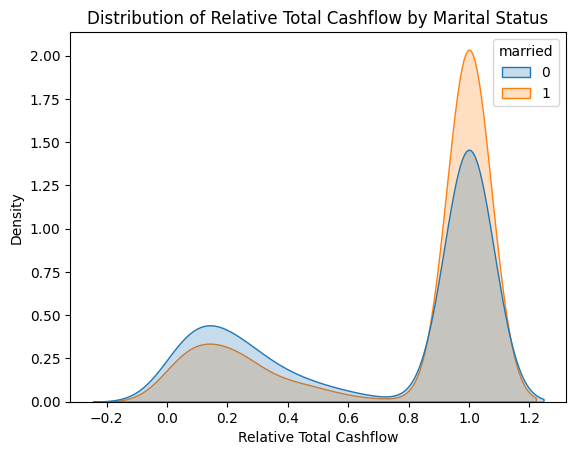

In [15]:
sns.kdeplot(data=mortgage, x='relative_cashflow', hue='married', fill=True)
plt.title('Distribution of Relative Total Cashflow by Marital Status')
plt.xlabel('Relative Total Cashflow')
plt.ylabel('Density')
plt.show()

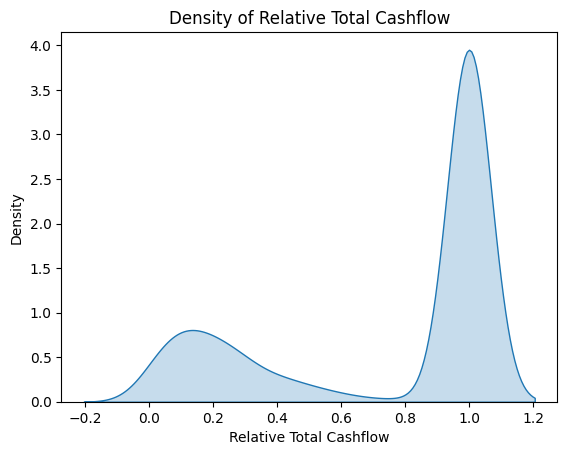

In [16]:
sns.kdeplot(data=mortgage['relative_cashflow'], fill=True)
plt.title('Density of Relative Total Cashflow')
plt.xlabel('Relative Total Cashflow')
plt.ylabel('Density')
plt.show()

In [17]:
mortgage = pd.get_dummies(mortgage, columns=['education'], prefix='edu', drop_first=True)

# Data

## Simple Default Data

In [18]:
simple_deafult_feature_cols = ['property_value', 'house_indicator', 'credit_score', 'married', 'num_dependents', 'coapplicant_indicator', 'interest_rate', 'pmt', 'adjusted_income']
simple_deafult_feature_cols += ['edu_Began Bachelors', 'edu_Graduate Degree', 'edu_High School']
X_simple_default = mortgage[simple_deafult_feature_cols]
y_simple_deafult = mortgage['default']
X_simple_default_train, X_simple_default_test, y_simple_default_train, y_simple_default_test = train_test_split(X_simple_default, y_simple_deafult, test_size=0.2, random_state=42)

## Yearly Default Data

In [19]:
yearly_default_feature_cols = ['property_value', 'house_indicator', 'credit_score', 'married', 'num_dependents', 'coapplicant_indicator', 'interest_rate', 'pmt', 'adjusted_income']
yearly_default_feature_cols += ['edu_Began Bachelors', 'edu_Graduate Degree', 'edu_High School'] 
yearly_default_output_cols = [f"default_{year}" for year in range(1, 31)]
X_yearly_default = mortgage[yearly_default_feature_cols]
y_yearly_deafult = mortgage[yearly_default_output_cols]
X_yearly_default_train, X_yearly_default_test, y_yearly_default_train, y_yearly_default_test = train_test_split(X_yearly_default, y_yearly_deafult, test_size=0.2, random_state=42)
train_indices = X_yearly_default_train.index
test_indices = X_yearly_default_test.index

# Models

## Simple Default Classification

In [20]:
model = LogisticRegression(max_iter=1000)
model.fit(X_simple_default_train, y_simple_default_train)

LogisticRegression(max_iter=1000)

In [21]:

simple_default_classification_train_probabilities = model.predict_proba(X_simple_default_train)[:, 1]
simple_default_classification_train_category = model.predict(X_simple_default_train)

simple_default_classification_train_auc_roc = roc_auc_score(y_simple_default_train, simple_default_classification_train_probabilities)
simple_default_classification_train_accuracy = accuracy_score(y_simple_default_train, simple_default_classification_train_category)

print(f'Simple Default Train AUC-ROC Score: {simple_default_classification_train_auc_roc}')
print(f'Simple Default Train Accuracy Score: {simple_default_classification_train_accuracy}')

simple_default_classification_test_probabilities = model.predict_proba(X_simple_default_test)[:, 1]
simple_default_classification_test_category = model.predict(X_simple_default_test)


simple_default_classification_test_auc_roc = roc_auc_score(y_simple_default_test, simple_default_classification_test_probabilities)
simple_default_classification_train_accuracy = accuracy_score(y_simple_default_test, simple_default_classification_test_category)

print(f'Simple Default Test AUC-ROC Score: {simple_default_classification_test_auc_roc}')
print(f'Simple Default Test Accuracy Score: {simple_default_classification_train_accuracy}')

Simple Default Train AUC-ROC Score: 0.8536169239591488
Simple Default Train Accuracy Score: 0.7795
Simple Default Test AUC-ROC Score: 0.8540464281133769
Simple Default Test Accuracy Score: 0.786


In [22]:
mortgage.loc[train_indices, 'predicted_default_classification_probability'] = simple_default_classification_train_probabilities
mortgage.loc[train_indices, 'predicted_default_category'] = simple_default_classification_train_category

mortgage.loc[test_indices, 'predicted_default_classification_probability'] = simple_default_classification_test_probabilities
mortgage.loc[test_indices, 'predicted_default_category'] = simple_default_classification_test_category

In [23]:
mortgage.head()

,loan_index,property_value,house_indicator,credit_score,married,num_dependents,annual_income,coapplicant_indicator,coapplicant_income,interest_rate,...,default_30,total_cashflow,relative_cashflow,years_of_cashflow,adjusted_income,edu_Began Bachelors,edu_Graduate Degree,edu_High School,predicted_default_classification_probability,predicted_default_category
0,0,1034333.55,1,689,0,0,183896.81,0,0.00,7.08,...,0.0,2016578.10,1.00,30.0,183896.810,False,False,False,0.148199,0.0
1,1,942811.10,1,620,0,0,182878.90,1,155627.09,7.25,...,0.0,1869472.80,1.00,30.0,229567.027,False,False,False,0.170971,0.0
2,2,438038.56,1,722,1,1,70405.18,0,0.00,7.00,...,1.0,197679.72,0.23,7.0,70405.180,True,False,False,0.436556,0.0
3,3,992154.42,1,636,1,2,135044.99,1,118209.66,7.21,...,1.0,1110404.81,0.57,17.0,170507.888,False,False,True,0.609402,1.0
4,4,628359.44,1,620,1,1,99933.09,0,0.00,7.25,...,0.0,1245955.50,1.00,30.0,99933.090,False,False,True,0.779249,1.0


## Yearly Default Classification

In [24]:
base_model = LogisticRegression(max_iter=1000)
multi_output_model = MultiOutputClassifier(base_model)
multi_output_model.fit(X_yearly_default_train, y_yearly_default_train)

MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000))

In [25]:
yearly_classification_test_probabilities = multi_output_model.predict_proba(X_yearly_default_test)
yearly_classificationtrain_probabilities = multi_output_model.predict_proba(X_yearly_default_train)

# the probabilities are a list of size 30 with each index being a 2 dimensional array with 1000 rows and 2 columns 
# the second column represents the probability of a default value 
# so by doing [:, 1] we get all of the rows and the second column of them which will be a 1 dimensional array of size 1000 
yearly_default_classification_test_probabilities = [probs[:, 1] for probs in yearly_classification_test_probabilities]
yearly_default_classification_train_probabilities = [probs[:, 1] for probs in yearly_classificationtrain_probabilities]

# Convert the list of arrays into a single 2D numpy array (years × mortgages)
yearly_classification_default_test_probabilities = np.array(yearly_default_classification_test_probabilities)
yearly_classification_default_train_probabilities = np.array(yearly_default_classification_train_probabilities)

In [26]:
yearly_default_classificaiton_train_auc_roc = roc_auc_score(y_yearly_default_train, yearly_classification_default_train_probabilities.T)
yearly_default_classificaiton_test_auc_roc = roc_auc_score(y_yearly_default_test, yearly_classification_default_test_probabilities.T)

print(f'Yearly Default Test AUC-ROC Score: {yearly_default_classificaiton_test_auc_roc}')
print(f'Yearly Default Train AUC-ROC Score: {yearly_default_classificaiton_train_auc_roc}')
    

Yearly Default Test AUC-ROC Score: 0.8204574751236688
Yearly Default Train AUC-ROC Score: 0.8154123636629268


In [27]:
for i in range (1, 31):
    mortgage.loc[test_indices, f'default_year_{i}_classification_probability'] = yearly_classification_default_test_probabilities[i-1]
    mortgage.loc[train_indices, f'default_year_{i}_classification_probability'] = yearly_classification_default_train_probabilities[i-1]

In [28]:
simple_default_regression_model = RandomForestRegressor()
simple_default_regression_model.fit(X_simple_default_train, y_simple_default_train)

RandomForestRegressor()

In [29]:
simple_default_regression_train_predicitons = simple_default_regression_model.predict(X_simple_default_train)
simple_default_regression_test_predicitons = simple_default_regression_model.predict(X_simple_default_test)

In [30]:
# Calculate Mean Squared Error
simple_default_test_mse = mean_squared_error(y_simple_default_test, simple_default_regression_test_predicitons)
simple_default_train_mse = mean_squared_error(y_simple_default_train, simple_default_regression_train_predicitons)
print("Simple Default Test Mean Squared Error:", simple_default_test_mse)
print("Simple Default Train Mean Squared Error:", simple_default_train_mse)

# Calculate Mean Squared Logarithmic Error
simple_default_test_msle = mean_squared_log_error(y_simple_default_test, simple_default_regression_test_predicitons)
simple_default_train_msle = mean_squared_log_error(y_simple_default_train, simple_default_regression_train_predicitons)
print("Simple Default Test Mean Squared Log Error:", simple_default_test_msle)
print("Simple Default Train Mean Squared Log Error:", simple_default_train_msle)


Simple Default Test Mean Squared Error: 0.14034069999999998
Simple Default Train Mean Squared Error: 0.01989465
Simple Default Test Mean Squared Log Error: 0.06953035810757217
Simple Default Train Mean Squared Log Error: 0.01058231260397502


In [31]:
mortgage.loc[train_indices, 'predicted_default_regression_probability'] = simple_default_regression_train_predicitons
mortgage.loc[test_indices, 'predicted_default_regression_probability'] = simple_default_regression_test_predicitons

In [32]:
# Choose your regression model
base_regressor = RandomForestRegressor()  # You can change this to any other regressor

# Create a multi-output regressor
multi_output_regressor = MultiOutputRegressor(base_regressor)

# Fit the multi-output regressor to the training data
multi_output_regressor.fit(X_yearly_default_train, y_yearly_default_train)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [33]:
yearly_default_regression_test_predicitons = multi_output_regressor.predict(X_yearly_default_test)
yearly_default_regression_train_predicitons = multi_output_regressor.predict(X_yearly_default_train)

In [34]:
# Calculate Mean Squared Error
yearly_default_test_mse = mean_squared_error(y_yearly_default_test, yearly_default_regression_test_predicitons)
yearly_default_train_mse = mean_squared_error(y_yearly_default_train, yearly_default_regression_train_predicitons)
print("Yearly Default Test Mean Squared Error:", yearly_default_test_mse)
print("Yearly Default Train Mean Squared Error:", yearly_default_train_mse)

# Calculate Mean Squared Logarithmic Error
yearly_default_test_msle = mean_squared_log_error(y_yearly_default_test, yearly_default_regression_test_predicitons)
yearly_default_train_msle = mean_squared_log_error(y_yearly_default_train, yearly_default_regression_train_predicitons)
print("Simple Default Test Mean Squared Log Error:", yearly_default_test_msle)
print("Simple Default Train Mean Squared Log Error:", yearly_default_train_msle)

Yearly Default Test Mean Squared Error: 0.12721318666666667
Yearly Default Train Mean Squared Error: 0.018541218333333335
Simple Default Test Mean Squared Log Error: 0.06390960775506688
Simple Default Train Mean Squared Log Error: 0.009623163017276812


In [35]:
transpose_yearly_default_regression_test_predicitons = yearly_default_regression_test_predicitons.T
transpose_yearly_default_regression_train_predicitons = yearly_default_regression_train_predicitons.T

In [36]:
for i in range (1, 31):
    mortgage.loc[test_indices, f'default_year_{i}_regression_probability'] = transpose_yearly_default_regression_test_predicitons[i-1]
    mortgage.loc[train_indices, f'default_year_{i}_regression_probability'] = transpose_yearly_default_regression_train_predicitons[i-1]

In [37]:
mortgage.head()
mortgage.columns.values

array(['loan_index', 'property_value', 'house_indicator', 'credit_score',
       'married', 'num_dependents', 'annual_income',
       'coapplicant_indicator', 'coapplicant_income', 'interest_rate',
       'pmt', 'pmt_1', 'pmt_2', 'pmt_3', 'pmt_4', 'pmt_5', 'pmt_6',
       'pmt_7', 'pmt_8', 'pmt_9', 'pmt_10', 'pmt_11', 'pmt_12', 'pmt_13',
       'pmt_14', 'pmt_15', 'pmt_16', 'pmt_17', 'pmt_18', 'pmt_19',
       'pmt_20', 'pmt_21', 'pmt_22', 'pmt_23', 'pmt_24', 'pmt_25',
       'pmt_26', 'pmt_27', 'pmt_28', 'pmt_29', 'pmt_30', 'default',
       'default_1', 'default_2', 'default_3', 'default_4', 'default_5',
       'default_6', 'default_7', 'default_8', 'default_9', 'default_10',
       'default_11', 'default_12', 'default_13', 'default_14',
       'default_15', 'default_16', 'default_17', 'default_18',
       'default_19', 'default_20', 'default_21', 'default_22',
       'default_23', 'default_24', 'default_25', 'default_26',
       'default_27', 'default_28', 'default_29', 'default_30'

In [38]:
def calculatePresentValue(df, rate):
    for idx, row in df.iterrows():
        presentValue = 0 
        for i in range(1, 31):
            A_i = row[f'pmt_{i}']
            presentValue += (A_i) / (pow((1 + rate), i))
        df.loc[idx, 'present_value'] = presentValue

def calculateSimpleDefaultPresentValue(df, rate, model):
    for idx, row in df.iterrows(): 
        presentValueSimpleDefault = 0 
        adjusted_annuity = row['pmt'] * (1 - row[f'predicted_default_{model}_probability'])
        for i in range(1, 31):
            presentValueSimpleDefault += (adjusted_annuity) / (pow((1 + rate), i))
        df.loc[idx, f'present_value_simple_default_{model}'] = presentValueSimpleDefault


def calculateYearlyDefaultPresentValue(df, rate, model):
    for idx, row in df.iterrows():
        presentValueYearlyDefault = 0 
        annuity = row['pmt']
        for i in range(1, 31): 
            A_i = annuity * (1 - row[f'default_year_{i}_{model}_probability'])
            presentValueYearlyDefault += (A_i) / (pow((1 + rate), i))
        df.loc[idx, f'present_value_yearly_default_{model}'] = presentValueYearlyDefault

In [39]:
calculatePresentValue(mortgage, 0.044)
calculateSimpleDefaultPresentValue(mortgage, 0.044, 'regression')
calculateSimpleDefaultPresentValue(mortgage, 0.044, 'classification')
calculateYearlyDefaultPresentValue(mortgage, 0.044, 'regression')
calculateYearlyDefaultPresentValue(mortgage, 0.044, 'classification')

In [46]:
mortgage['present_value']

0       1.107926e+06
1       1.027105e+06
2       1.670203e+05
3       7.705427e+05
4       6.845393e+05
            ...     
4995    3.770109e+05
4996    8.303023e+05
4997    5.328345e+05
4998    9.485146e+04
4999    4.398704e+05
Name: present_value, Length: 5000, dtype: float64

In [45]:
mortgage['simple_default_classification_profit'] = mortgage['present_value'] - mortgage['present_value_simple_default_classification']
mortgage['simple_default_regression_profit'] = mortgage['present_value'] - mortgage['present_value_simple_default_regression']
mortgage['yearly_default_classification_profit'] = mortgage['present_value'] - mortgage['present_value_yearly_default_classification']
mortgage['yearly_default_regression_profit'] = mortgage['present_value'] - mortgage['present_value_yearly_default_regression']

print (f"Profit of simple default risk using classificaiton: ${mortgage['simple_default_classification_profit'].sum():,.2f}")
print (f"Profit of simple default risk using regression:  ${mortgage['simple_default_regression_profit'].sum():,.2f}")
print (f"Profit of yearly default risk using classificaiton: ${mortgage['yearly_default_classification_profit'].sum():,.2f}")
print (f"Profit of yearly default risk using regression: ${mortgage['yearly_default_regression_profit'].sum():,.2f}")

Profit of simple default risk using classificaiton: $390,417,676.00
Profit of simple default risk using regression:  $394,305,515.46
Profit of yearly default risk using classificaiton: $9,171,187.03
Profit of yearly default risk using regression: $20,873,280.30


In [47]:
present_value = 0
for i in range (1, 9):
    present_value += (28239.96) / (pow((1 + 0.044), i))
present_value


187030.9330325587

In [49]:

for idx, row in mortgage.iterrows():
    if (idx == 0):
        presentValue = 0 
        for i in range(1, 31):
            A_i = row[f'pmt_{i}']
            presentValue += (A_i) / (pow((1 + 0.044), i))
        print(present_value)

187030.9330325587
